# Try to fit resonances using two different models

## Model 1

### $ S_{21}(\nu) = |\frac{\sqrt{k_1 k_2}}{1 + k_1 + k_2 + iQ_0\delta}| $
### $\delta = \frac{\omega}{\omega_0} - \frac{\omega_0}{\omega}$

In [1]:
import emcee
import numpy as np
import corner
import matplotlib.pyplot as plt
import plot_settings
from scipy.linalg import det
from numpy import log, sqrt
from emcee.moves import StretchMove

In [ ]:
url = "https://raw.githubusercontent.com/biqute/QTLab2425/refs/heads/main/3Dqubit/data/empty_cavity_power_sweep/40mK_1.0kHz_-5dBm.csv"
data = np.loadtxt(url, delimiter=",", skiprows=1, usecols=(0, 1, 2), unpack=True)

In [3]:
F = data[0]
mag = np.abs(data[1] + 1j * data[2])

Plot data

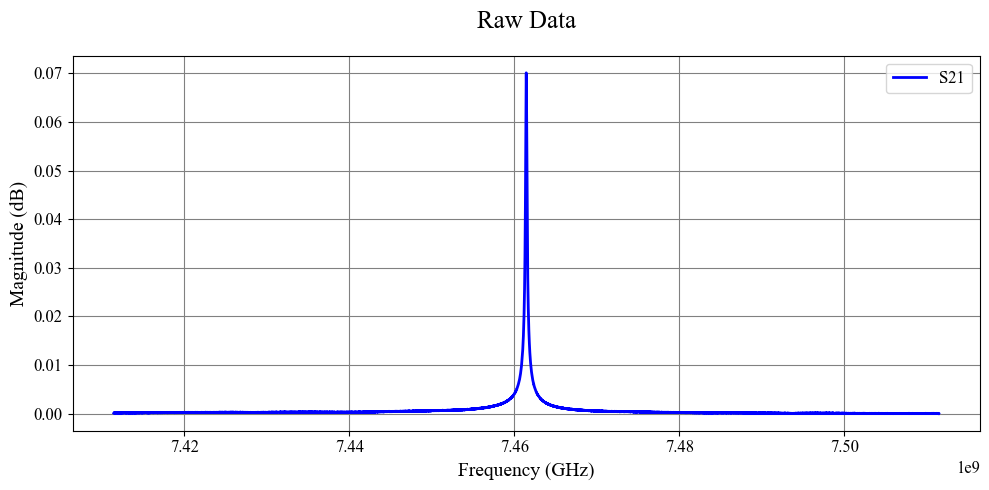

In [4]:
plt.plot(F, mag, label="S21", color='blue', linewidth=2)
plt.title("Raw Data")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude (dB)")
plt.legend()

Center around maximum and scale frequencies

In [5]:
F = data[0][np.argmax(np.abs(data[1]))-100:np.argmax(np.abs(data[1]))+100]
S = data[1][np.argmax(np.abs(data[1]))-100:np.argmax(np.abs(data[1]))+100] + 1j * data[2][np.argmax(np.abs(data[1]))-100:np.argmax(np.abs(data[1]))+100]

In [6]:
F = (F - F[np.argmax(abs(S))])*1e-6
A = np.abs(S)

Aerr = np.ones_like(A) * 0.001
Ferr = np.ones_like(F) * 0.001

err = np.sqrt(Aerr**2 + Ferr**2)

sigma = np.sqrt(Aerr[0]**2 + Ferr[0]**2)

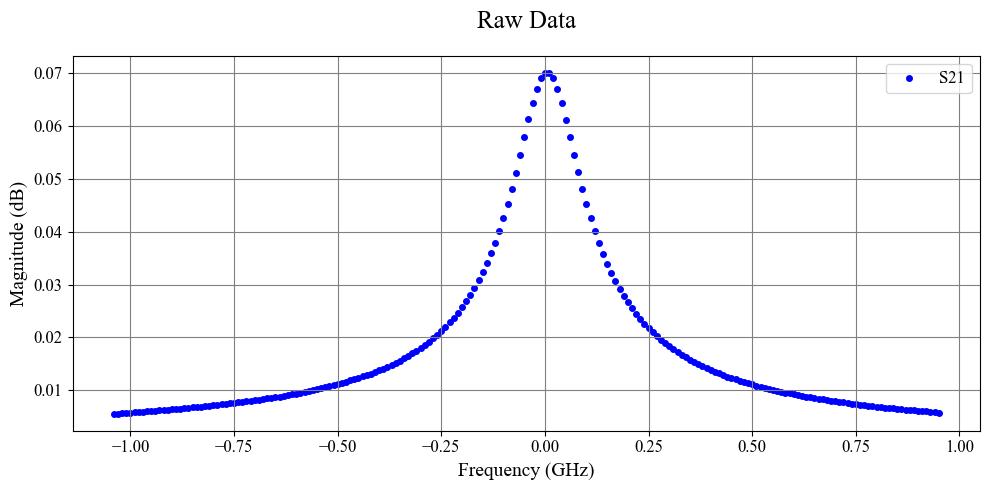

In [7]:
plt.scatter(F, A, marker='.', label="S21", color='blue', linewidth=2)
plt.title("Raw Data")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude (dB)")
plt.legend()

In [22]:
def logmodel(x):
    """
    Resonance model using reparameterized log-space inputs:
    x = [log_kk, delta_k, log_Q0, nu0]
    """
    log_kk, delta_k, log_Q0, nu0 = x

    # Recover log_k1, log_k2
    log_k1 = 0.5 * (log_kk + delta_k)
    log_k2 = 0.5 * (log_kk - delta_k)

    k1 = 10**log_k1
    k2 = 10**log_k2
    Q0 = 10**log_Q0

    denom = (1 + k1 + k2)**2 + (Q0 * (F - nu0))**2
    response = np.sqrt((k1 * k2) / denom)
    return response

def model(x):
    """
    Resonance model 
    x = [k1, k2, Q0, nu0]
    """
    
    k1, k2, Q0, nu0 = x
    
    alpha = F/nu0 - nu0/F
    
    num = 2 * np.sqrt(k1*k2)
    den1 = 1 + k1 + k2 + 1j * Q0 * alpha
    den2 = 1 + k1 + k2
    
    return np.where(F/nu0 != 0, np.abs(num/den1), np.abs(num/den2))

In [45]:
#guess_params = np.array([np.log10(3), np.log10(200), np.log10(3.2*1e2), 0.9*1e-2])
guess_params  = np.array([1e5, 200, 20000, 0.9*1e-2])

C:\Users\ricca\AppData\Local\Temp\ipykernel_3828\371431277.py:28: RuntimeWarning: divide by zero encountered in divide
  alpha = F/nu0 - nu0/F
C:\Users\ricca\AppData\Local\Temp\ipykernel_3828\371431277.py:31: RuntimeWarning: invalid value encountered in multiply
  den1 = 1 + k1 + k2 + 1j * Q0 * alpha
C:\Users\ricca\AppData\Local\Temp\ipykernel_3828\371431277.py:34: RuntimeWarning: invalid value encountered in divide
  return np.where(F/nu0 != 0, np.abs(num/den1), np.abs(num/den2))


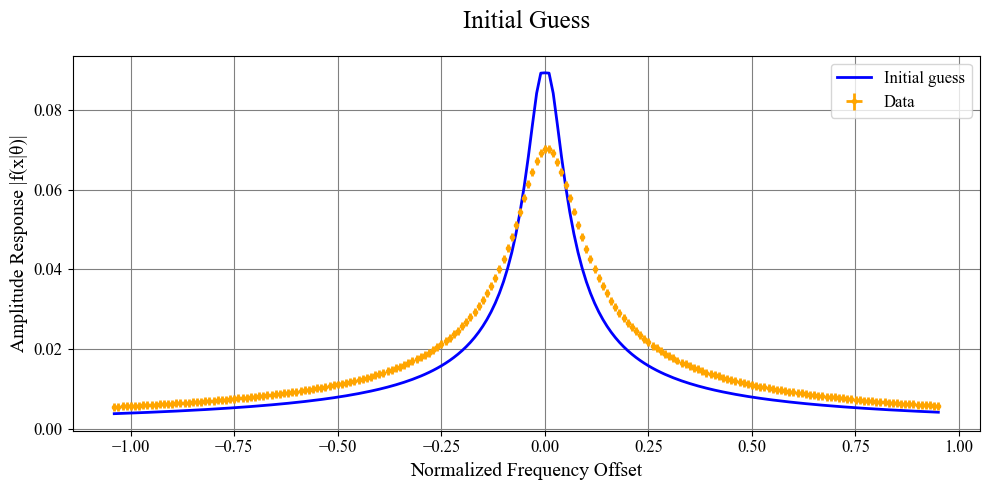

In [46]:
plt.plot(F, model(guess_params),label="Initial guess", color='blue', markersize=5)
plt.errorbar(F, A, xerr=Ferr, yerr=Aerr,label="Data", color='orange', linewidth=2, fmt='.')
plt.title("Initial Guess")
plt.xlabel("Normalized Frequency Offset")
plt.ylabel("Amplitude Response |f(x|θ)|")
#plt.text(-1, 0.05, r"$k_1=8$, $k_2=0.05$, $Q_0=1e2$, $\nu_0=0.9e-2$", fontsize=12, color='black')
plt.legend()

In [ ]:
def log_prior(x):
    log_kk, delta_k, log_Q0, nu0 = x

    # We recover log_k1 and log_k2 to check if they're valid
    log_k1 = 0.5 * (log_kk + delta_k)
    log_k2 = 0.5 * (log_kk - delta_k)

    # Parameter ranges
    log_k_min, log_k_max = -5, 5       # for k1, k2 ∈ [1e-3, 1e3]
    log_Q_min, log_Q_max = 1, 6        # for Q0 ∈ [10, 1e5]
    nu0_min, nu0_max = -0.1, 0.1       # physical frequency window

    if (
        log_k_min < log_k1 < log_k_max and
        log_k_min < log_k2 < log_k_max and
        log_Q_min < log_Q0 < log_Q_max and
        nu0_min < nu0 < nu0_max
    ):
        return -np.log(nu0_max - nu0_min)  # flat prior on all, normalized nu0
    else:
        return -np.inf
    
    def prior(x):
        
        k1, k2, Q0, nu0 = x
        
        
        
        return 


In [33]:
def log_likelihood(x):
    y_model = model(x)
    return -0.5 * np.sum(((A - y_model) / err) ** 2)

def log_posterior(x):
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(x)

In [34]:
ndim     = 4  # number of parameters in the model
nwalkers = 40  # number of MCMC walkers
nsteps   = int(1e5)  # number of MCMC steps to take **for each walker**

In [35]:
guess_parameters = guess_params + np.random.randn(nwalkers, ndim) * 1e-5

In [36]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, moves=StretchMove(a=3.5))

In [37]:
sampler.run_mcmc(guess_parameters, nsteps)

State([[-8.64950696e-01  2.11882791e+00  1.82436796e+00  4.04979895e-03]
 [-1.92993820e+00 -1.37341260e+00  1.28480378e+00  4.79118355e-03]
 [-1.23456244e+00  2.01131230e+00  1.63096794e+00  4.70131280e-03]
 [-1.24647594e+00  2.00884436e+00  1.62388262e+00  4.70132869e-03]
 [-1.95693241e+00  1.28678312e+00  1.27375546e+00  2.39269879e-03]
 [ 2.34639415e+00  2.28878209e+00  3.42289735e+00  4.06689455e-03]
 [ 1.09068587e-01  2.25432193e+00  2.30146740e+00  5.41250584e-03]
 [ 6.72250131e+00  2.29635558e+00  5.61892650e+00  4.73234727e-03]
 [ 3.33897139e+00  2.29732269e+00  3.92008121e+00  2.81481540e-03]
 [-2.16980979e+00  1.00133729e-01  1.16166032e+00  5.19671473e-03]
 [-2.06625011e+00 -9.54405983e-01  1.21474334e+00  5.77343115e-03]
 [ 3.97970710e-01  2.26388853e+00  2.44474220e+00  4.26993620e-03]
 [ 3.06880680e+00  2.29281806e+00  3.78205561e+00  5.20771402e-03]
 [ 1.39173760e+00  2.28971211e+00  2.95116760e+00  3.57677139e-03]
 [-2.16416262e+00 -2.68531259e-01  1.16747724e+00  4.805

In [38]:
tau = sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [5774.92119808 7514.70119849 5775.2224914   317.87837489]

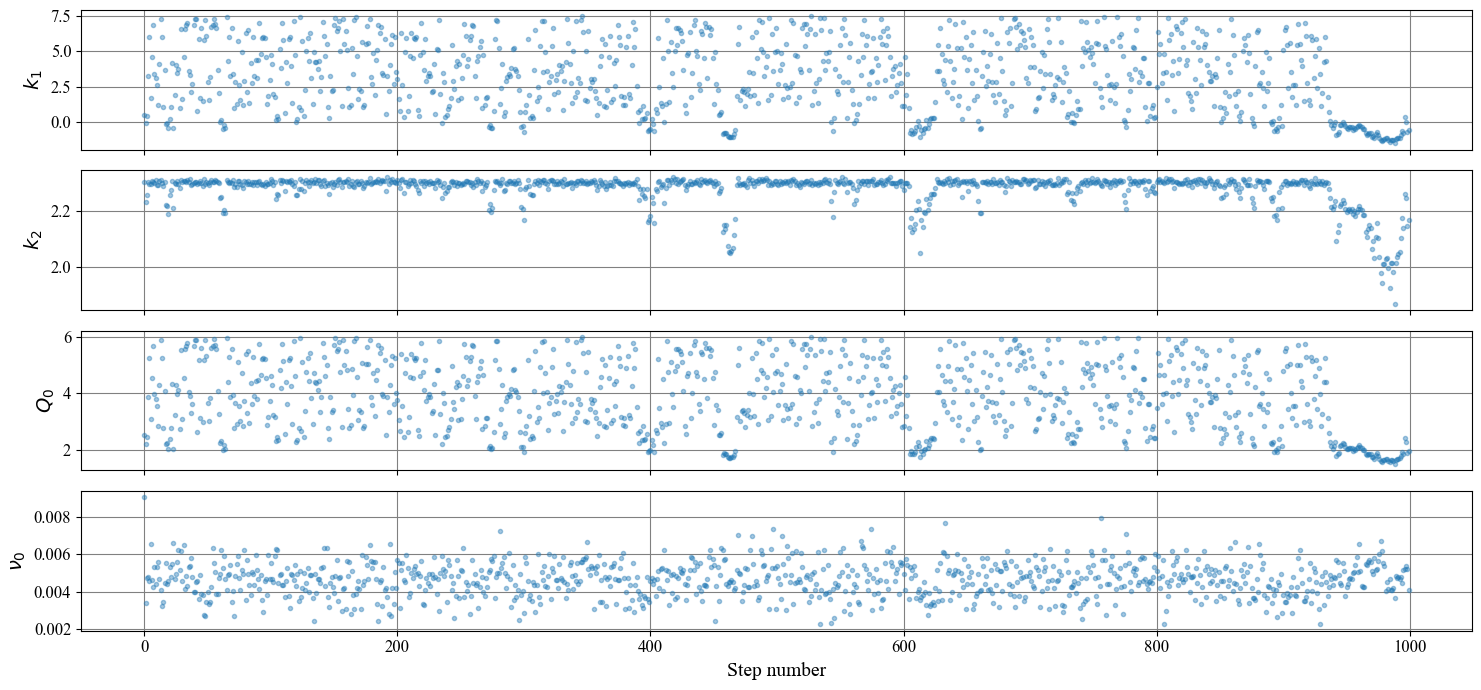

In [39]:
labels = [r"$k_1$", r"$k_2$", r"$Q_0$", r"$\nu_0$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[::100,0,i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [40]:
burn_idx = 5000

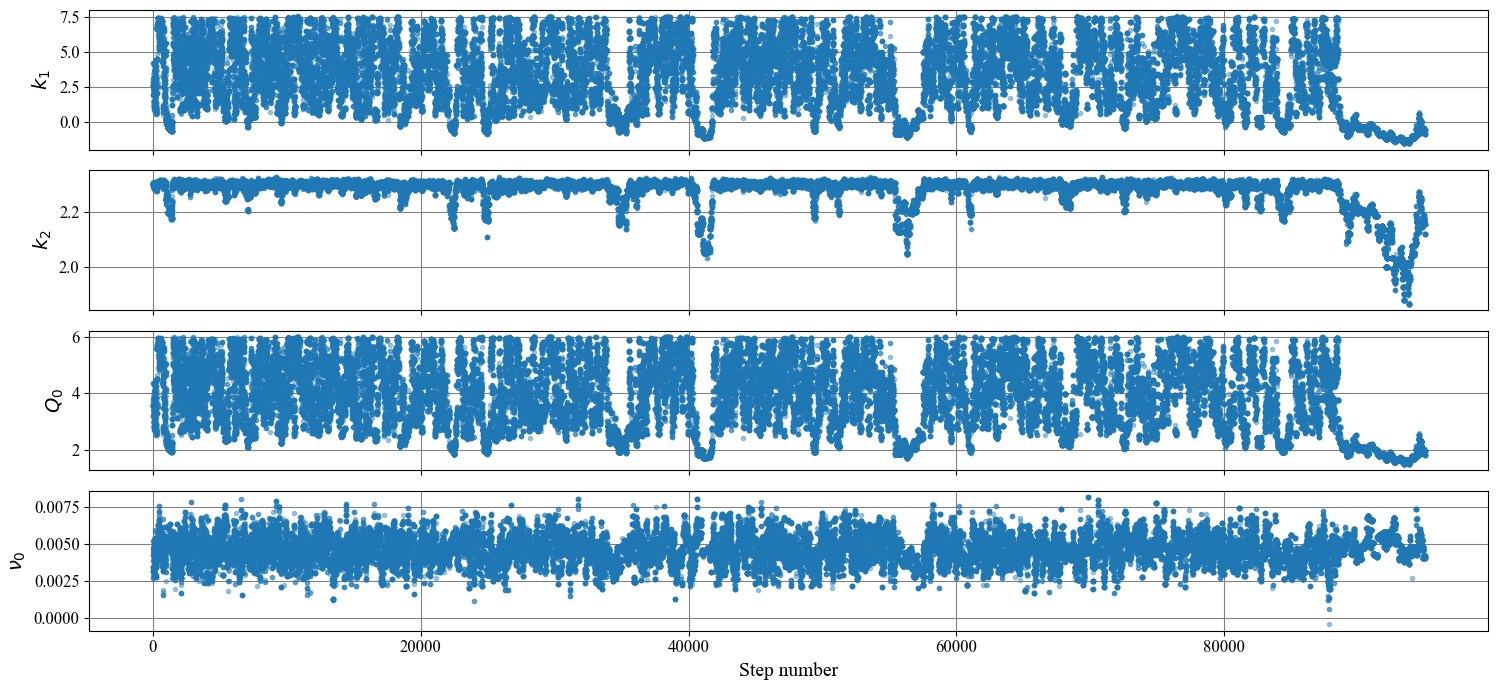

In [41]:
labels = [r"$k_1$", r"$k_2$", r"$Q_0$", r"$\nu_{0}$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[burn_idx:, 0, i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [42]:
samples = sampler.get_chain(flat=False, discard=burn_idx)
flat_samples = sampler.get_chain(flat=True, discard=burn_idx)#, thin=int(max(tau)))

In [43]:
quantiles = np.array([16, 50, 95])

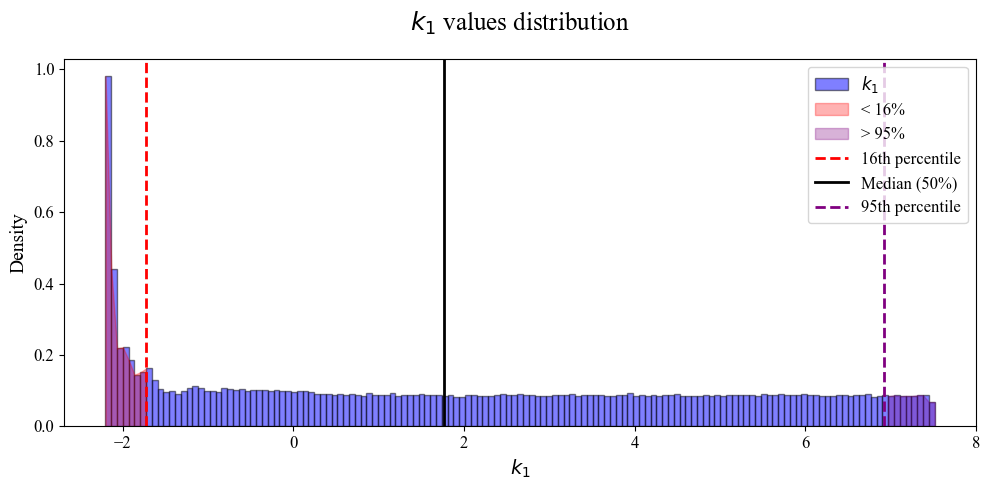

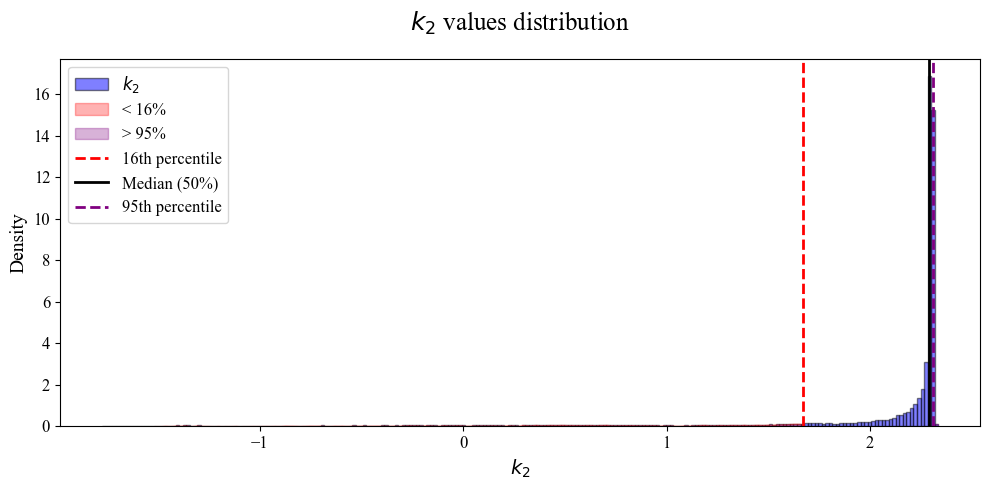

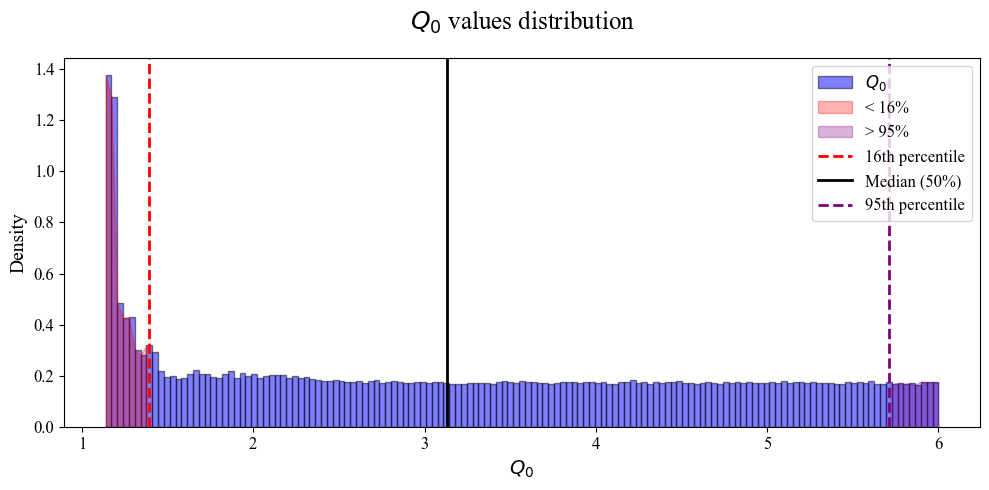

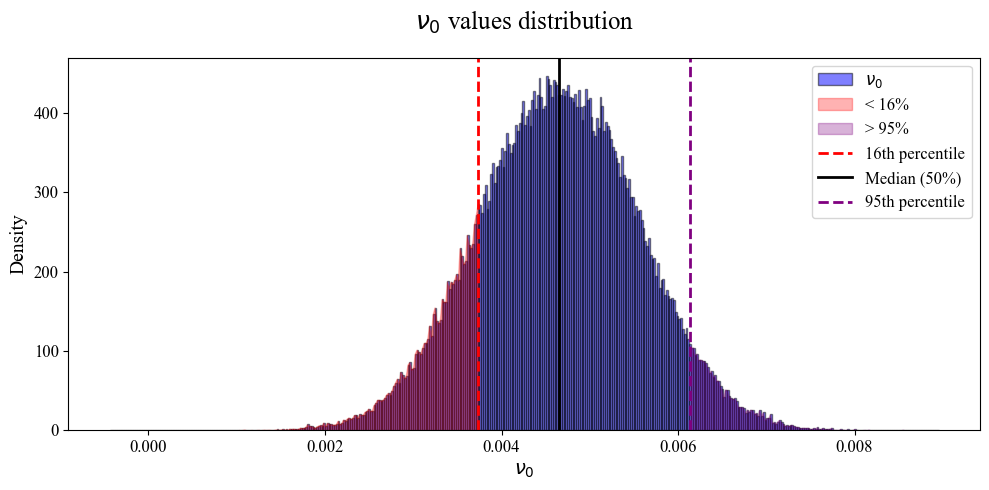

In [ ]:
for i in range(4):
    q16, q50, q95 = np.percentile(flat_samples[:, i], quantiles)
    
    counts, bins, _ = plt.hist(flat_samples.T[i], bins='scott', density=True, histtype='barstacked', label=labels[i], alpha=0.5, color='blue', edgecolor='black')
    
    # Fill <16%
    mask_low = bins <= q16
    plt.fill_between(bins[mask_low], 0, np.interp(bins[mask_low], bins[:-1], counts), color='red', alpha=0.3, label='< 16%')

    # Fill >95%
    mask_high = bins >= q95
    plt.fill_between(bins[mask_high], 0, np.interp(bins[mask_high], bins[:-1], counts), color='purple', alpha=0.3, label='> 95%')

    # Vertical lines
    plt.axvline(q16, color='red', linestyle='--', label='16th percentile')
    plt.axvline(q50, color='black', linestyle='-', label='Median (50%)')
    plt.axvline(q95, color='purple', linestyle='--', label='95th percentile')
    
    
    plt.ylabel('Density')
    plt.xlabel(labels[i])
    plt.legend()
    plt.title(labels[i]+" values distribution")
    plt.show()

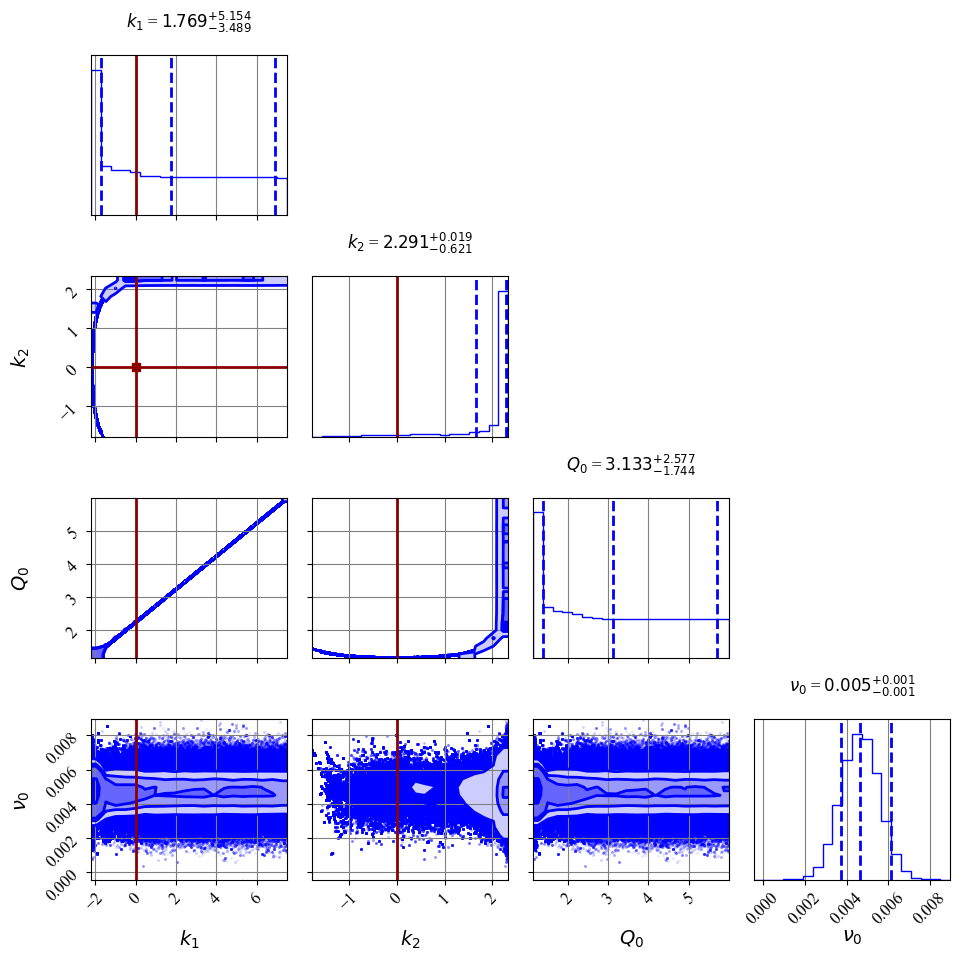

In [45]:
# Define true values (make sure vals is defined appropriately)
true_values = np.array([
    max(A) / 2,
    np.mean(A[:20]),
    0.2,
    50
])

# Generate corner plot
fig = corner.corner(
    flat_samples,
    labels=labels,  # customize these labels as needed
    truths=true_values,
    quantiles=quantiles*0.01,
    show_titles=True,
    title_fmt=".3f",              # Number format in titles
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    truth_color="darkred",
    color="blue",
    fill_contours=True
)

In [61]:
mcmc_estimates[1,0]

np.float64(1.7686647409572909)

In [ ]:
mcmc_estimates = np.percentile(flat_samples, q=quantiles, axis=0)

for i, label in enumerate(labels):
    median = 10**mcmc_estimates[1, i])
    minus  = median * (1 - 10**mcmc_estimates[0, i])
    plus   = median * (10**mcmc_estimates[2, i] - 1)

In [70]:
median

np.float64(1.010754450958743)

In [53]:
x_vals = np.random.uniform(0, samples.shape[0], 100).astype(int)
walker = np.random.randint(0, samples.shape[1], 1).astype(int)
p0 = samples[x_vals,walker,0]
p1 = samples[x_vals,walker,1]
p2 = samples[x_vals,walker,2]
p3 = samples[x_vals,walker,3]

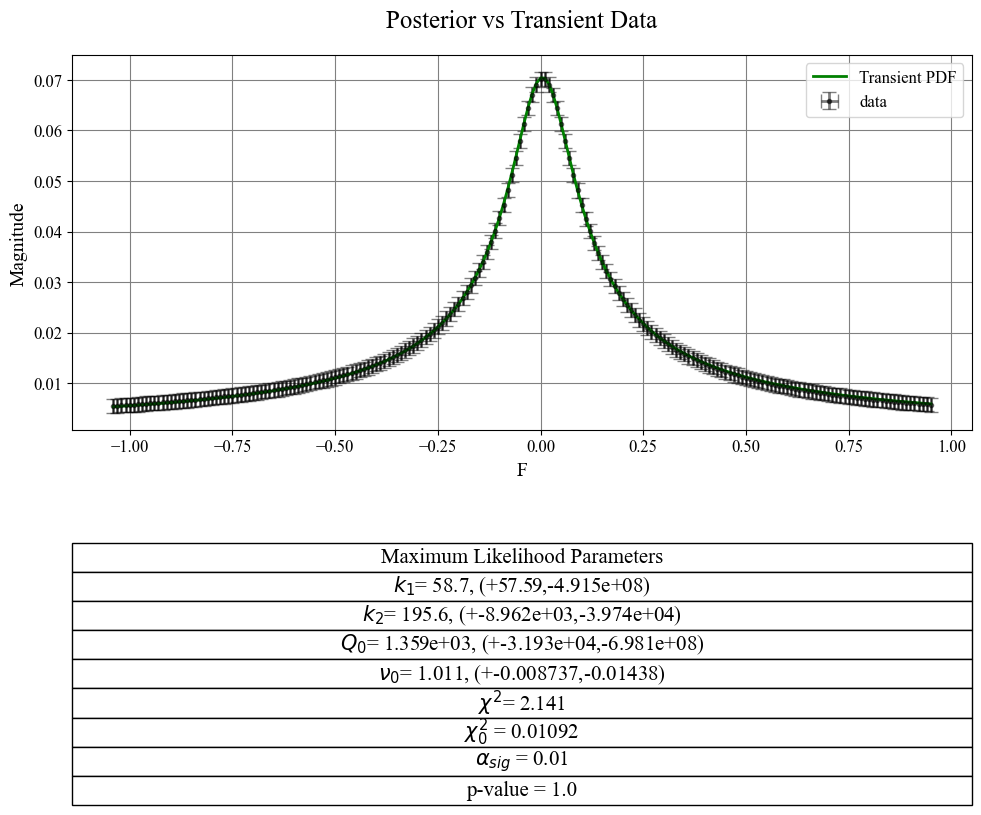

In [75]:
from scipy.stats import chi2 as CHI2

plt.figure(figsize=(10, 5))
plt.errorbar(F, A, xerr=0, yerr=err,capsize=5, fmt=".", label="data", color='black', alpha=0.5)
plt.plot(F,model(np.array([mcmc_estimates[1, 0],mcmc_estimates[1, 1],mcmc_estimates[1, 2],mcmc_estimates[1, 3]])),color='green', label="Transient PDF", linewidth=2)

plt.table(cellText=[[r"$k_1$"+f"= {10**(mcmc_estimates[1, 0]):.4}, (+{10**mcmc_estimates[1,0]*(1-10**mcmc_estimates[0,0]):.4},-{10**mcmc_estimates[1,0]*(10**mcmc_estimates[2,0]-1):.4})"],
                    [r"$k_2$"+f"= {10**(mcmc_estimates[1, 1]):.4}, (+{10**mcmc_estimates[1,1]*(1-10**mcmc_estimates[0,1]):.4},-{10**mcmc_estimates[1,1]*(10**mcmc_estimates[2,1]-1):.4})"],
                    [r"$Q_0$"+f"= {10**(mcmc_estimates[1, 2]):.4}, (+{10**mcmc_estimates[1,2]*(1-10**mcmc_estimates[0,2]):.4},-{10**mcmc_estimates[1,2]*(10**mcmc_estimates[2,2]-1):.4})"],
                    [r"$\nu_0$"+f"= {10**(mcmc_estimates[1, 3]):.4}, (+{10**mcmc_estimates[1,3]*(1-10**mcmc_estimates[0,3]):.4},-{10**mcmc_estimates[1,3]*(10**mcmc_estimates[2,3]-1):.4})"],
                    [r"$\chi^{2}$"+f"= {-2 * log_likelihood(mcmc_estimates[1]):.4}"],
                    [r"$\chi_0^{2}$"+f" = {-2 * log_likelihood(mcmc_estimates[1]) / (len(A) - 4):.4}"],
                    [r"$\alpha_{sig}$ = 0.01"],
                    [f"p-value = {CHI2.sf(-2 * log_likelihood(mcmc_estimates[1]), len(A) - 4):.4}"]],
         colLabels=["Maximum Likelihood Parameters"], loc='bottom', cellLoc='center', bbox=[0, -1, 1, 0.7], fontsize=15)

plt.xlabel('F')
plt.ylabel('Magnitude')
plt.title('Posterior vs Transient Data')
plt.legend()